### Question

Is there a relationship between review sentiment, review length, and star rating of reviews and can we predict star rating with the others? Could we exploit this to help produce more balanced reviewing by suggesting to reviewers a star rating based on their written review?


### Rationale
1. We want to investigate the relationship between the sentiment, length, and rating of reviews to better understand how they are related.
2. In addition, we can use this information to explore possible ways of improving the overall quality and structure of reviews.

### Data
Our data contains customer reviews from different restaurants around Blacksburg. It comes in a pre-cleaned CSV format and was provided by the instructor. We will use Pandas to import the file in to a DataFrame.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import all of the data from the CSV file in to a DataFrame
reviews = pd.read_csv('Homework09.csv')
reviews.head()

,Restaurant,Author,Date,Stars,Text,Useful
0,Cabo Fish Taco,Mark M.,1/21/2019,5.0,"The tortilla chips were good, the salsa was re...",2.0
1,Cabo Fish Taco,K.P K.,3/2/2019,4.0,Nice variety of appetizers and entree's.Well s...,0.0
2,Cabo Fish Taco,Thomas N.,12/23/2018,5.0,Living in Blacksburg for the past 3 years I've...,0.0
3,Cabo Fish Taco,Miller G.,12/22/2018,5.0,This is easily my favorite restaurant in Black...,0.0
4,Cabo Fish Taco,Lori W.,11/4/2018,5.0,"TACOS! there is A good reason ""taco"" is in the...",0.0


We now have a DataFrame containing all of the review data from the CSV file. Each review includes five additional features: the review's author, date, star rating, and usefulness in addition to the restaurant that was reviewed. 

Now we want to create a new DataFrame that will include only the sentiment, length, and star rating of each review. For the sentiment of each review, we will categorize them as either positive or negative based on a ratio of the difference of positive and negative words to the total amount of words in the text. In addition, the lengths of each review will be based on their word count after removing stopwords.

In [2]:
# Gets the sentiment of each review
positives = set(open("positive.txt").read().split())
negatives = set(open("negative.txt").read().split())
stopwords = set(open("stopwords.txt").read().split())
reviews["bag"] = reviews.Text.map(lambda t: t.replace(',',' ').lower().split())
reviews["bag"] = reviews.bag.map(lambda b: [w for w in b if w not in stopwords])

reviews["positive_words_count"] = reviews.bag.map(lambda b: len([w for w in b if w in positives]))
reviews["negative_words_count"] = reviews.bag.map(lambda b: len([w for w in b if w in negatives]))
reviews["pn_difference"] = (reviews.positive_words_count - reviews.negative_words_count) / reviews.bag.map(len)
reviews["Sentiment"] = reviews.pn_difference.map(lambda x: "Positive" if x >= 0 else "Negative")

# Gets the length of each review
review_lengths = reviews.bag.map(len)
review_lengths

# Creates the new DataFrame
d = {
    "Length": review_lengths,
    "Stars": reviews.Stars,
    "Sentiment": reviews.Sentiment
    }

analysisDF = pd.DataFrame(d)
analysisDF

,Length,Stars,Sentiment
0,41,5.0,Positive
1,30,4.0,Positive
2,100,5.0,Positive
3,71,5.0,Positive
4,87,5.0,Positive
...,...,...,...
1650,15,4.0,Positive
1651,42,4.0,Positive
1652,31,4.0,Positive
1653,40,4.0,Positive


At this point we have created our new DataFrame.

Before we begin exploring a possible relationship between these features, we should look at a few visualizations to gain a greater insight into possible skewness and limitations of our data. We will look at a pie chart of the value counts of the different Star ratings as well as the Sentiments to see what the distributions will be. We will also look at a bar chart of the distribution between positive and negative reviews for the different star ratings.

<AxesSubplot:title={'center':'Value Counts of Star Ratings'}, ylabel='Stars'>

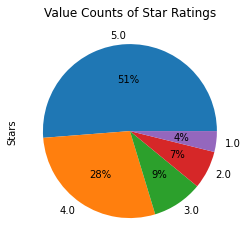

In [3]:
# Plots the value counts of Star ratings
analysisDF.Stars.value_counts().plot(kind="pie", autopct="%1.0f%%", title= "Value Counts of Star Ratings")

From this chart we can see that about half of all reviews gave out 5 stars and only about 20% gave out 1, 2, and 3 star reviews combined. This tells us there is some clear skewness in the distribution of star ratings which can have negative effects on our analysis. Particularly, it may lead to multiple reviews with 5 stars but a negative sentiment.

<AxesSubplot:title={'center':'Value Counts of Sentiment'}, ylabel='Sentiment'>

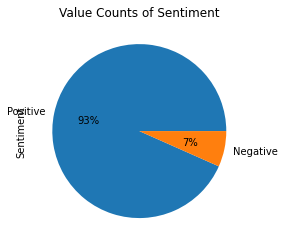

In [4]:
# Plots the value counts of Sentiment
analysisDF.Sentiment.value_counts().plot(kind="pie", autopct="%1.0f%%", title= "Value Counts of Sentiment")

From this chart we can see that the vast majority of reviews have positive sentiment. This also tells us there is some skewness in the data, possibly due to limitations in the method used to obtain the sentiments of each review. While the vast majority of reviews recieved 4 or 5 stars, we can see there is still a portion of positive reviews that must have come from low starred reviews.

Sentiment,Negative,Positive
Stars,,
1.0,26,38
2.0,19,98
3.0,11,144
4.0,23,448
5.0,31,817


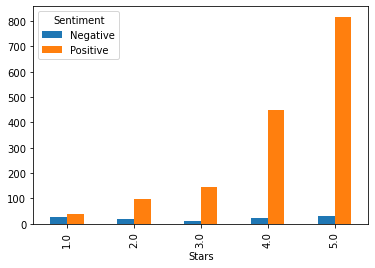

In [5]:
sentiments = analysisDF.groupby(['Stars','Sentiment']).Sentiment.count().unstack()
sentiments.plot(kind="bar")
sentiments

From this chart we can clearly see there is error in our sentiment analysis. For example, there were 31 reviews that gained 5 stars but were classified as negative. Furthermore, there were 98 reviews that gained 2 stars but were classified as positive, making there more positive than negative 1 star ratings. This tells us there must have been 5 star reviews with a negative relationship between their use of positive and negative words, as well as 1 and 2 star reviews with a positive relationship between their use of positive and negative words. This is a caveat of working with text analysis, and is likely due to the author's syntax.

Now that we have visualized the data and covered possible issues and shortcomings from it, we can perform correlation and regression analysis to understand if there is a relationship between the features. In order to do this we must first change the positive and negative sentiments to 1 and -1, respectively. 

In [6]:
# New DataFrame only with the numerical sentiments
analysisDF["num_sentiment"] = analysisDF.Sentiment.map(lambda s: 1 if s == "Positive" else -1)
regDF = analysisDF.drop("Sentiment", axis=1)

# Find the correlation between the features
len_stars = regDF.Length.corr(regDF.Stars)
len_sent = regDF.Length.corr(regDF.num_sentiment)
stars_sent = regDF.Stars.corr(regDF.num_sentiment)

print(len_stars, len_sent, stars_sent)

-0.19592599859946905 -0.0020554387012207942 0.2507463740086936


From the above correlation calculations, there appears to be a small relationship between the number of stars and the sentiment, which is to be expected. Furthermore the big take away from the above cell is that length does not appear to affect the rating or the sentiment of any reviews.

Now lets try to see how well we can predict the star rating of reviews based on sentiment and length using a multiple linear regression model.

<AxesSubplot:ylabel='Frequency'>

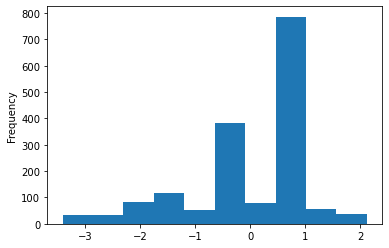

In [7]:
from sklearn.linear_model import LinearRegression

inputs = regDF.loc[:,["Length", "num_sentiment"]]
lm = LinearRegression()
lm.fit(inputs, regDF.Stars)

regDF["StarsPredicted"] = lm.predict(inputs)
regDF.StarsPredicted

error = regDF.Stars - regDF.StarsPredicted

error.plot.hist(bins=10)

We can see from the plot above that our regression model was fairly good, but not great, at predicting the star ratings of different reviews, with most of the error falling in the range from 0.5 to 1 stars off. 

While this model does provide a prediction of the star rating with use of the other features, lets now try to use a decision tree to predict star rating and see how its predictions compare to the regression model's. In addition, we will use testing data in our decision tree regression.

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

x = regDF.drop(["Stars", "StarsPredicted"], axis=1)
y = regDF.Stars

(x_train, x_test, y_train, y_test) = train_test_split(x, y, test_size=0.25)

regressor = DecisionTreeRegressor()
regressor.fit(x_train,y_train)

y_pred = regressor.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
regDF.Stars.mean()



Mean Absolute Error: 0.9276808129991433


4.1613293051359515

From this regression model we can see that the decision tree is also not very accurate in its predictions of the star ratings. We can see that the mean absolute error in these predictions is around 20% of the total mean of the star ratings, which is not a good prediction error rate. This means that there does not appear to be a strong relationship between review sentiment, review length, and star rating of reviews. In addition, this also means that we will not be able to accurately predict suggested star ratings for authors. In the future, it might be helpful to have a more even distribution of star ratings as well as an improved method for finding sentiments. 